In [1]:
import shutil # copy, move file
import os # miscellaneous operation system interfaces
import pathlib
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import random

tf.random.set_seed(102)
np.random.seed(102)
DATA_RAW_FOLDER = './work/simple_flask/data/Faceshape/train1'
DATA_ROOT_FOLDER = './work/simple_flask/data/Faceshape' 
DATA_TRAIN_FOLDER = './work/simple_flask/data/Faceshape/train'
DATA_TEST_FOLDER = './work/simple_flask/data/Faceshape/test'

In [2]:
print('TensorFLow version:', tf.__version__)
print('GPU available:', tf.test.is_gpu_available())

TensorFLow version: 2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available: False


In [3]:
def create_folder_or_reset_folder(folder_path):
    if os.path.isdir(folder_path):
        shutil.rmtree(folder_path)
        os.mkdir(folder_path)
        print('Removed and created', folder_path)
    else:
        os.mkdir(folder_path)
        print('Created new', folder_path)
    
    for folder_name in class_names:
        os.mkdir(os.path.join(folder_path, folder_name))
        
def clean_ipynb_folder_if_exists(folder=DATA_ROOT_FOLDER):
    folder = pathlib.Path(folder)
    ipynb_paths = [str(item) for item in folder.glob('**/*') if item.is_dir() and item.name.startswith('.ipynb')]
    if len(ipynb_paths) > 0:
        for eachdir in ipynb_paths:
            shutil.rmtree(eachdir)
            print("Removed", eachdir)
    else:
        print('No .ipynb_checkpoints to remove')

In [4]:
# Clean .ipynb_checkpoints
clean_ipynb_folder_if_exists()

No .ipynb_checkpoints to remove


In [5]:
raw_folder =  pathlib.Path(DATA_RAW_FOLDER)
class_names = [str(item.name) for item in raw_folder.glob('*/') if item.is_dir()]
print(class_names)
class_names = np.array(sorted(class_names, key=lambda x: str(x)))

NUM_CLASSES = len(class_names)

all_image_paths = [str(item) for item in raw_folder.glob('*/*') if item.is_file()]
all_image_labels = [str(item.parent.name) for item in raw_folder.glob('*/*') if item.is_file()]

assert len(all_image_paths) == len(all_image_labels)

['Square', 'Oblong', 'Heart', 'Round', 'Oval']


In [6]:
# Create empty train and test folder
create_folder_or_reset_folder(DATA_TRAIN_FOLDER)
create_folder_or_reset_folder(DATA_TEST_FOLDER)

Removed and created ./work/simple_flask/data/Faceshape/train
Removed and created ./work/simple_flask/data/Faceshape/test


In [7]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_image_labels, test_image_labels = train_test_split(all_image_paths, all_image_labels, test_size=0.2, random_state=101)

print('Split data: {} for training and {} for testing'.format(len(train_image_paths), len(test_image_paths)))

Split data: 1785 for training and 447 for testing


In [8]:
assert len(train_image_paths) + len(test_image_paths) == len(all_image_paths)

In [9]:
IMAGE_WIDTH, IMAGE_HEIGHT = 192, 192

def resize_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
    return image

def load_and_resize_image(path):
    image = tf.io.read_file(path)
    return resize_image(image)

def images_preprocessing_and_saving(folder_path, image_paths, image_labels):
    new_paths = []
    for index, image_path in enumerate(image_paths):
        try:
            file_name = '{}.jpg'.format(index)
            new_path = os.path.join(folder_path, image_labels[index], file_name)
            preprocessed_image = load_and_resize_image(image_path)
            tf.keras.preprocessing.image.save_img(new_path, preprocessed_image, data_format='channels_last')
            new_paths.append(new_path)
            if (index % 100 == 0) and (index > 0):
                print('Processed {} images '.format(index))
        except:
            print("File error {}".format(image_path))
    return new_paths

def show_batch(image_batch, label_batch):
    '''Show batch of 25 images.
    
    Parameters:
        image_batch: paths to the images, len(image_path) >= 25
        label_batch: labels of the images (str)
    '''
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n].title())
        plt.axis('off')

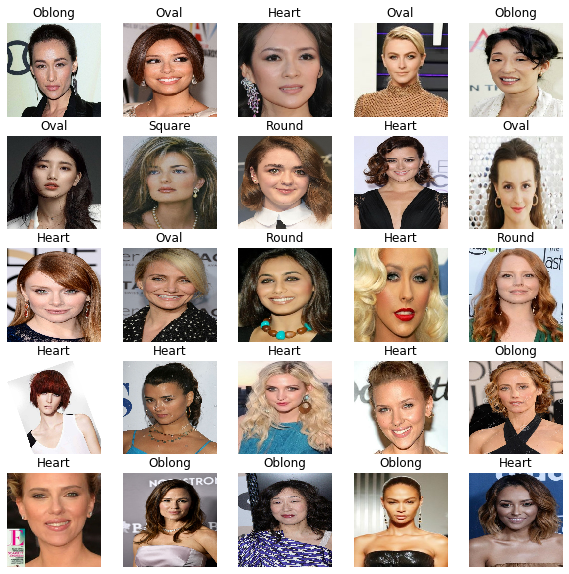

In [10]:
image_batch = [load_and_resize_image(path)/255 for path in train_image_paths[:25]]
label_batch = train_image_labels[:25]
show_batch(image_batch , label_batch)

In [11]:
train_image_paths = images_preprocessing_and_saving(DATA_TRAIN_FOLDER, train_image_paths, train_image_labels)

Processed 100 images 
Processed 200 images 
Processed 300 images 
Processed 400 images 
Processed 500 images 
Processed 600 images 
Processed 700 images 
Processed 800 images 
Processed 900 images 
Processed 1000 images 
File error work/simple_flask/data/Faceshape/train1/Heart/heart (633).jpg
Processed 1100 images 
File error work/simple_flask/data/Faceshape/train1/Oblong/oblong (724).jpg
Processed 1200 images 
Processed 1300 images 
Processed 1400 images 
Processed 1500 images 
Processed 1600 images 
Processed 1700 images 


In [12]:
test_image_paths = images_preprocessing_and_saving(DATA_TEST_FOLDER, test_image_paths, test_image_labels)

Processed 100 images 
Processed 200 images 
Processed 300 images 
File error work/simple_flask/data/Faceshape/train1/Square/square (84).jpg
Processed 400 images 


In [13]:
TRAIN_SAMPLES = 1500
TEST_SAMPLES = 300
BATCH_SIZE = 32

AUTOTUNE = tf.data.experimental.AUTOTUNE
STEPS_PER_TRAIN_EPOCH = tf.math.ceil(TRAIN_SAMPLES/BATCH_SIZE)
STEPS_PER_TEST_EPOCH = tf.math.ceil(TEST_SAMPLES/BATCH_SIZE)

In [14]:
train_ds = tf.data.Dataset.list_files(os.path.join(DATA_TRAIN_FOLDER, '*','*'))
test_ds = tf.data.Dataset.list_files(os.path.join(DATA_TEST_FOLDER, '*','*'))

for f in train_ds.take(5):
    print(f.numpy())

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == class_names

def preprocess(path):
    label = get_label(path)
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = (image*2) - 1  # normalize to [-1,1] range
    image = tf.image.per_image_standardization(image)
    return image, label

def augmentation(image, label):
    image = tf.image.random_brightness(image, .1)
    image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label
    
def prepare_for_training(ds, cache=True, shuffle_buffer_size=100, augment=False):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    
    if augment:
        ds.map(augmentation, num_parallel_calls=AUTOTUNE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

b'./work/simple_flask/data/Faceshape/train/Heart/115.jpg'
b'./work/simple_flask/data/Faceshape/train/Oval/202.jpg'
b'./work/simple_flask/data/Faceshape/train/Square/588.jpg'
b'./work/simple_flask/data/Faceshape/train/Oblong/1293.jpg'
b'./work/simple_flask/data/Faceshape/train/Oval/1377.jpg'
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Image shape:  (192, 192, 3)
Label:  [False False False False  True]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

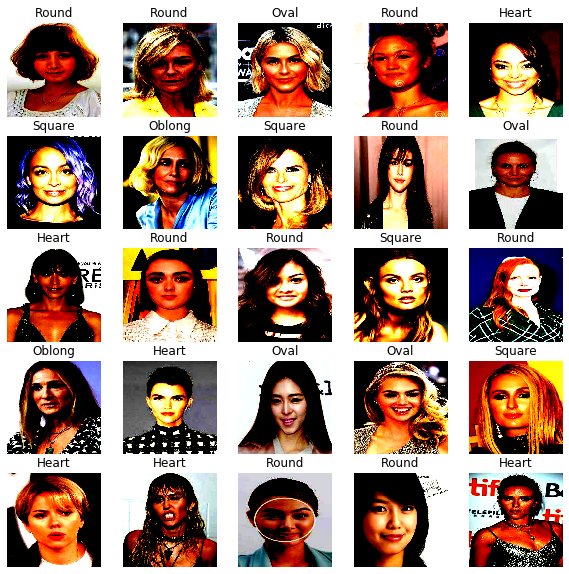

In [15]:
train_ds = prepare_for_training(train_ds, shuffle_buffer_size=TRAIN_SAMPLES, augment=True)
test_ds = prepare_for_training(test_ds, cache=False, shuffle_buffer_size=TEST_SAMPLES)

image_batch, label_batch = next(iter(train_ds))
label_batch = [class_names[np.argmax(label)] for label in label_batch.numpy()]
show_batch(image_batch, label_batch)

In [16]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        # reset_metrics: the metrics returned will be only for this batch. 
        # If False, the metrics will be statefully accumulated across batches.
        self.model.reset_metrics()
  
    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['acc'])
        # reset_metrics: the metrics returned will be only for this batch. 
        # If False, the metrics will be statefully accumulated across batches.
        self.model.reset_metrics()

def plot_stats(training_stats, val_stats, x_label='Training Steps', stats='loss'):
    stats, x_label = stats.title(), x_label.title()
    legend_loc = 'upper right' if stats=='loss' else 'lower right'
    training_steps = len(training_stats)
    test_steps = len(val_stats)

    plt.figure()
    plt.ylabel(stats)
    plt.xlabel(x_label)
    plt.plot(training_stats, label='Training ' + stats)
    plt.plot(np.linspace(0, training_steps, test_steps), val_stats, label='Validation ' + stats)
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc=legend_loc)
    plt.show()

batch_stats_callback = CollectBatchStats()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.RMSprop(lr=0.0001),
              metrics=['acc'])

num_steps_train = tf.math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)              
num_steps_val = tf.math.ceil(float(TEST_SAMPLES)/BATCH_SIZE)              

history = model.fit(train_ds,
                    steps_per_epoch = num_steps_train,
                    epochs=5,
                    validation_data = test_ds,
                    validation_steps = num_steps_val,
                    callbacks=[batch_stats_callback],
                    initial_epoch=0)

Train for 47.0 steps, validate for 10.0 steps
Epoch 1/5
47/47 [==============================] - 42s 888ms/step - loss: 1.8374 - acc: 0.1875 - val_loss: 1.8384 - val_acc: 0.2500
Epoch 2/5
47/47 [==============================] - 37s 784ms/step - loss: 1.7435 - acc: 0.2188 - val_loss: 1.7826 - val_acc: 0.1250
Epoch 3/5
39/47 [=======================>......] - ETA: 5s - loss: 1.6965 - acc: 0.4062

In [ ]:
model.save('./model/faceshape2.h5')